In [8]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timeit
import pandas as pd
import os,shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import layers ,models

In [4]:
dim_x=224
dim_y=224
batch_size=32

In [18]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
                                                  'image',
                                                  validation_split=0.3,
                                                  subset="training",
                                                  seed=1,
                                                  image_size=(dim_x, dim_y),
                                                  batch_size=batch_size,
                                                  label_mode='binary',
                                                  shuffle=True)
valid_ds=tf.keras.preprocessing.image_dataset_from_directory(
                                                  'image',
                                                  validation_split=0.3,
                                                  subset="validation",
                                                  seed=1,
                                                  image_size=(dim_x, dim_y),
                                                  batch_size=batch_size,
                                                  label_mode='binary',
                                                  shuffle=True)
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
                                                  'test',
                                                  image_size=(dim_x, dim_y),
                                                  batch_size=batch_size,
                                                  shuffle=True)

Found 25000 files belonging to 2 classes.
Using 17500 files for training.
Found 25000 files belonging to 2 classes.
Using 7500 files for validation.
Found 12500 files belonging to 1 classes.


In [9]:
filenames= os.listdir('./train') 
labels=[]
for name in filenames:     
    list_of_split_name= name.split('.')[0]             
    if list_of_split_name == 'dog':         
        labels.append('dog')     
    else:         
        labels.append('cat') 

In [10]:
df_train= pd.DataFrame({ 'filename' : filenames ,'label': labels})
df_test= pd.DataFrame({ 'filename' : filenames ,'label': labels})
df_train.head(10)

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
5,cat.10000.jpg,cat
6,cat.10001.jpg,cat
7,cat.10002.jpg,cat
8,cat.10003.jpg,cat
9,cat.10004.jpg,cat


In [11]:
train_df, valid_df = train_test_split(df_train , test_size= 0.3 , random_state= 42, stratify=df_train['label'], shuffle=True) 
train_df= train_df.reset_index(drop=True)  
valid_df= valid_df.reset_index(drop=True)

In [12]:
train_data= keras.preprocessing.image.ImageDataGenerator(rescale=1./255 ,                                                          
                                                         rotation_range=20,                                                          
                                                         horizontal_flip=True,                                                          
                                                         vertical_flip=True,
                                                        validation_split=0.2) 
train_generator=train_data.flow_from_dataframe( dataframe=train_df,                                                 
                                                directory='./train',                                                
                                               target_size=(dim_x, dim_y),                                                 
                                               x_col="filename",                                                 
                                               y_col="label",                                                 
                                               color_mode="rgb",                                                 
                                               class_mode="binary",                                                 
                                               batch_size=32,                                                 
                                               seed = 42,                                                 
                                               shuffle=True,
                                               subset='training'
                                               )
valid_data=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                       validation_split=0.2)  
valid_generator=valid_data.flow_from_dataframe( dataframe=df_train,
                                               directory='./train',
                                               target_size=(dim_x, dim_y),
                                               x_col="filename",
                                               y_col="label",
                                               color_mode="rgb",
                                               class_mode="binary",
                                               batch_size=32,
                                               seed = 42,
                                               shuffle=True,
                                               subset='validation')

Found 14000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation((-0.2,0.3)),
  layers.Rescaling(1./255)
])

In [20]:
inp = layers.Input(shape=(dim_x, dim_y, 3))
# inp =data_augmentation(inp)
x = tf.keras.applications.EfficientNetB0(input_shape=(dim_x, dim_y, 3),include_top=False, weights='imagenet')(inp)
# x.trainable = True
# for i,layer in enumerate(x.layers):
#     if i ==100:
#         break
    # layer.trainable = False
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1,activation='sigmoid')(x)
model = tf.keras.models.Model(inputs = inp, outputs = output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_3 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1281

In [21]:
model.compile(
    optimizer='adam',     
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    verbose=True)

Epoch 1/10
547/547 [==============================] - 91s 153ms/step - loss: 0.1292 - accuracy: 0.9524 - val_loss: 0.0716 - val_accuracy: 0.9736
Epoch 2/10
547/547 [==============================] - 82s 150ms/step - loss: 0.0743 - accuracy: 0.9735 - val_loss: 0.0537 - val_accuracy: 0.9799
Epoch 3/10
547/547 [==============================] - 83s 151ms/step - loss: 0.0554 - accuracy: 0.9798 - val_loss: 0.0753 - val_accuracy: 0.9747
Epoch 4/10
547/547 [==============================] - 83s 152ms/step - loss: 0.0479 - accuracy: 0.9830 - val_loss: 0.0688 - val_accuracy: 0.9773
Epoch 5/10
547/547 [==============================] - 82s 150ms/step - loss: 0.0401 - accuracy: 0.9863 - val_loss: 0.0575 - val_accuracy: 0.9799
Epoch 6/10
547/547 [==============================] - 82s 151ms/step - loss: 0.0375 - accuracy: 0.9869 - val_loss: 0.0512 - val_accuracy: 0.9812
Epoch 7/10
547/547 [==============================] - 83s 151ms/step - loss: 0.0361 - accuracy: 0.9869 - val_loss: 0.0611 - val_ac

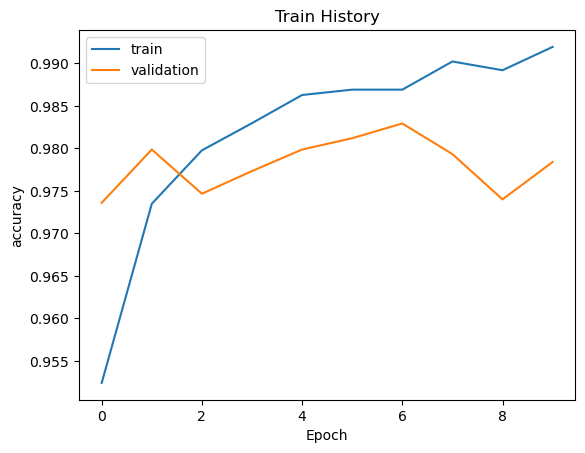

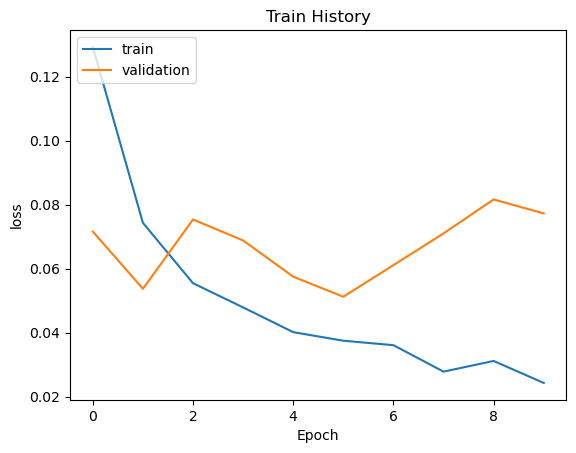

In [22]:
def show_train_history(train_history, train, validation):        
    plt.plot(train_history.history[train])        
    plt.plot(train_history.history[validation])        
    plt.title('Train History')        
    plt.ylabel(train)        
    plt.xlabel('Epoch')        
    plt.legend(['train', 'validation'], loc='upper left')        
    plt.show()        
    # 画出准确率执行结果  
show_train_history(history, 'accuracy', 'val_accuracy')  
    # 画出误差执行结果  
show_train_history(history, 'loss', 'val_loss')

In [28]:
predict = model.evaluate(valid_generator)

157/157 [==============================] - 48s 279ms/step - loss: 0.1592 - accuracy: 1.0000


In [ ]:
predict = model.predict(valid_generator)
predict = [1 if x > 0.5 else 0 for x in predict]
test_df['category'] = predict